<center><font size = "10"> Week 4 - Cable Theory <center>
<center><font size = "8">Home work<center>

#### Group: Group 1

# Ex1: Voltage variation in space

<font size="3">Create a simple morphology with only one section called soma, as it is done in tutorial 01 of this week 4, point 1. Perform a curret clamp experiment in which the stimulation has the following parameters: delay 1 ms, amplitud 1 nA and duration 10 ms. Then do the following:
    
<font size="3">- instead of injecting current at the middle of the section, inject current simultaneously at the two endpoints
        
<font size="3">- without changing the morphology, increase the voltage attenuation from the center of the section to the ends. 
     

<font size="3">Plot the result for each of the previous points and explain what is happening in each situation. In this exercise is important to keep the previous values each time you change some parameter.
If not, you won’t be able to compare them.
    
[0.5 points]

In [102]:
# Importing Libraries

%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

In [103]:
# Global containers for objects
stimdictlst = [] # stimulations
vdictlst = []    # voltage recordings
idictlst = []    # current recordings

def reset():
    del stimdictlst[:]
    del vdictlst[:]
    del idictlst[:]

# Inject a current step with parameters at location
def iclamp(location, delay, amplitude, duration):
    stim = h.IClamp(location) # Place a stimulation electrode at location
    stim.delay = delay   # stim delay (ms)
    stim.amp = amplitude # stim amplitude (pA)
    stim.dur = duration  # stim duration (ms)
    stimdictlst.append({ 'stim': stim, 'loc': str(location) })
    return stim

# Setup recording of voltage at location
def vrecord(location):
    vec = h.Vector()
    vec.record(location._ref_v) # record voltage at location
    vdictlst.append({ 'vec': vec, 'loc': str(location) })
    return vec

# Setup recording of stimulation current
def irecord(stimdict):
    vec = h.Vector()
    vec.record(stimdict['stim']._ref_i) # record stimulation current
    idictlst.append({ 'vec': vec, 'loc': stimdict['loc'] })
    return vec

# Initialize and run a simulation
def initrun(v_i,t_stop):
    # Record time
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record current for all stimuli
    for stimdict in stimdictlst:
        irecord(stimdict)
    # Setup simulation and run
    h.load_file('stdrun.hoc')
    h.finitialize(v_i) # initial voltage
    h.continuerun(t_stop) # final time
    return rec_t

# Plot current and voltage for all stims and recordings
def tvi_plots(t, vdictlst, idictlst, vmax = 70, imax = 2):
    plt.figure()
    plt.title('currents')
#     plt.ylim((-0.01,5))
    plt.xlabel('t (ms)')
    plt.ylabel('I (nA)')
    for i, idict in enumerate(idictlst):
        plt.plot(t,idict['vec'],label=('Soma'+str(i)))
#     plt.legend(loc=1)
    
    plt.figure()
    plt.title('voltages')
#     plt.ylim((-71,vmax))
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    for vdict in vdictlst:
        plt.plot(t,vdict['vec'],label='Soma(0.5)')
    plt.legend(loc=1)
    
    
def transposeRecording(reclist, nloc, tstop):
    retlist = []  
    # each element of reclist is a neuron.h.Vector of recordings for one out of nloc spatial locations
    # (usually compartment centers) over time
    for i in range(0,int(tstop/h.dt)+1):
        retlist.append(h.Vector(nloc,0)) 
        for j in range(0,nloc):
            retlist[i].x[j] = reclist[j].x[i]
    return retlist

In [104]:
# Create a section 
soma = h.Section()
soma.Ra = 0.0000001
soma.L = 100
soma.diam = 10
soma.cm = 1
soma.nseg = 11

In [105]:
# Inject a current step into the soma
reset()
delay = 1 #ms
amp = 1 #nA
dur = 10 #ms
stim_1 = iclamp(soma(0), delay, amp, dur)
stim_2 = iclamp(soma(1), delay, amp, dur)
vec_v = vrecord(soma(0.5))

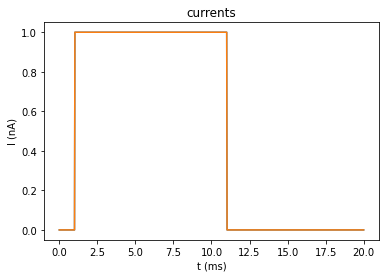

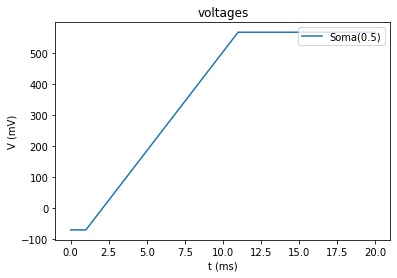

In [106]:
# Simulate and plot
v_init = -70
t_stop = 20
tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

Text(0.5, 1.0, 'Spatial distribution at t = 1.025 ms')

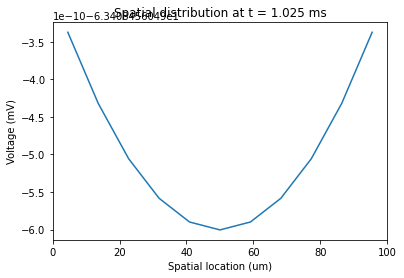

In [107]:
reclist = h.List()

for i in range(0,soma.nseg):
    tmpRecVec = h.Vector()
    tmpRecVec.record(soma((0.5 + i*1.0)/soma.nseg)._ref_v)
    reclist.append(tmpRecVec)
    
h.init()
h.run(11)
xlocations = h.Vector()

for i in range(0,soma.nseg):
    xlocations.append(soma.L*(0.5 + i*1.0)/(soma.nseg))

spatialrec = transposeRecording(reclist, soma.nseg, 5)
fig = plt.figure()
plt.plot(xlocations, spatialrec[41]) # 1.025/0.025 = 41
plt.ylabel("Voltage (mV)")
plt.xlabel("Spatial location (um)")
plt.title("Spatial distribution at t = 1.025 ms")

#### - What is happening in this first situation:
When plotting the recorded current and voltage in the middle of the soma (soma(0.5)) without any voltage attenuation, the steepness of linear voltage response is the combination of both injections.  Indeed, when we delay one of the injection compared to the other, we notice that the voltage ramps is divided into two steepness and there is coherent dissymmetry.

Moreover, when plotting the spatial distribution of the voltage, one can notice a decrease when moving to the middle of the soma.  This highlights the leaky effects of the cable properties of the membrane.  Indeed, the amplitude of the voltage measure decreases as we move away from the current injection points.

#### - Without changing the morphology, increase the voltage attenuation from the center of the section to the ends:

In [108]:
# Create a section 
soma = h.Section()
soma.Ra = 1
soma.L = 100
soma.diam = 10
soma.cm = 1
soma.nseg = 11

In [109]:
# Inject a current step into the soma
reset()
delay = 1 #ms
amp = 1 #nA
dur = 10 #ms

In [110]:
def plot_currents(ax, idictlst, t, legend=True):
    ax.set_title('Currents')
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('I (nA)')
    for i, idict in enumerate(idictlst):
        ax.plot(t, idict['vec'],label=('Soma'+str(i)))
    if legend:
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

def plot_voltages(ax, vdictlst, t, ra, legend=True):
    ax.set_title('Voltages')
    ax.set_ylabel('V (mV)')
    ax.set_xlabel('t (ms)')
    for vdict in vdictlst:
        ax.plot(t,vdict['vec'],label='Ra= '+str(int(ra))+' Ω*cm')
    if legend:
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

def plot_spatial_dist(ax, x_locations, spatialrec, t_selected, ra, legend=True):
    ax.plot(xlocations, spatialrec[t_selected], label='Ra= '+str(int(ra))+' Ω*cm') # 1.025/0.025 = 41
    ax.set_ylabel("Voltage (mV)")
    ax.set_xlabel("Spatial location (um)")
    ax.set_title("Spatial distribution at t = 1.025 ms")
    if legend:
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

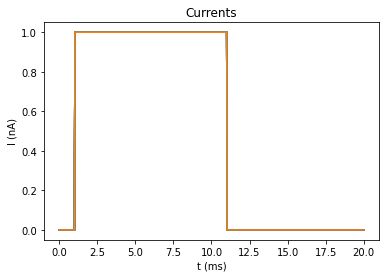

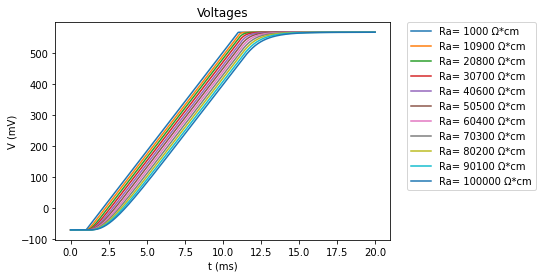

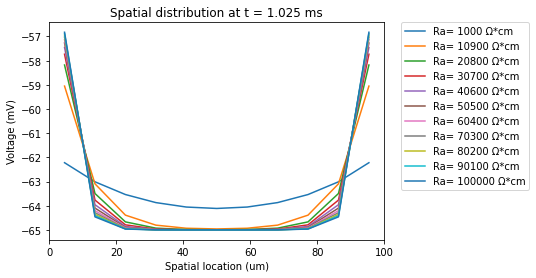

In [111]:
v_init = -70
t_stop = 20
Ra_values = np.linspace(1000,100000,11)
fig_curr = plt.figure()
ax1 = fig_curr.add_subplot(1,1,1)
fig_volt = plt.figure()
ax2 = fig_volt.add_subplot(1,1,1)
fig_spatial_dist = plt.figure()
ax3 = fig_spatial_dist.add_subplot(1,1,1)

for ra in Ra_values:
    reset()
    soma.Ra = ra
    stim_1 = iclamp(soma(0.5/soma.nseg), delay, amp, dur)
    stim_2 = iclamp(soma(10.5/soma.nseg), delay, amp, dur)
    vec_v = vrecord(soma(5.5/soma.nseg))
    
    reclist = h.List()
    for i in range(0, soma.nseg):
        tmpRecVec = h.Vector()
        tmpRecVec.record(soma((0.5 + i*1.0)/soma.nseg)._ref_v)
        reclist.append(tmpRecVec)

    h.init()
    h.run(11)
    xlocations = h.Vector()

    for i in range(0,soma.nseg):
        xlocations.append(soma.L*(0.5 + i*1.0)/(soma.nseg))

    spatialrec = transposeRecording(reclist, soma.nseg, 5)
    
    # Simulate and plot
    plot_currents(ax1, idictlst, initrun(v_init,t_stop), legend=False)
    plot_voltages(ax2, vdictlst, initrun(v_init,t_stop), ra)
    plot_spatial_dist(ax3, xlocations, spatialrec, 41, ra)




#### - What is happening in second situation:

When increasing the axial resisitivity, the length constant from the cable equation is reduced.  As a result, in order to increase the voltage attenuation, one therefore needs to increase the axial resisitivity.  Indeed, from the plots above, when increasing the voltage attenuation, one can see in the spatial distribution at the same time point of the recording, a steeper reduction in the voltage amplitude when reaching the middle of the soma.  Interestingly, when increasing the R values (thus increasing the time-constant), the low-pass filter properties of the membrane (modeled as an RC circuit) can be noted: the time-voltage plots show a smoothing of the function.

# Ex 2. Action Potential Propagation. 

<font size='3'>Create a neuron with a soma, an axon with three sections, and a dendrite with three branches, each of the branches with different diameters but with the same length. Add passive properties to every section and add active properties (hh) to the soma, axon and the dendrite, but not to the branches. You can use the parameters from tutorial 02. Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma and the branches are recorded at the far end. Choose the best stimulation parameters to see the signal attenuation in the branches.
    
<font size='3'>Explain with your own words:
    
<font size='3'>- What are passive and active membrane properties?
    
<font size='3'>- What is going on with the signal propagation from the soma to the branches?
    
<font size='3'>- What happen if the active properties of the dendrite are removed?
    
<font size='3'>- Record the potential at the end of the axon. What happens if the active properties of the middle axonal section are removed? What could this represent biologically?
    
[1.5 points]

In [112]:
%matplotlib inline

from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

In [113]:
# Functions needed to run simulation and record (put here again, supposing that we have restarted the kernel in between exo 1 and exo 2)

# Global containers for objects
stimdictlst = [] # stimulations
vdictlst = []    # voltage recordings
idictlst = []    # current recordings

# Convenience functions for setting up stimulation, recording and simulation

def reset():
    del stimdictlst[:]
    del vdictlst[:]
    del idictlst[:]

# Inject a current step with parameters at location
def iclamp(location, delay = 100, amplitude = 0.1, duration = 500):
    stim = h.IClamp(location) # Place a stimulation electrode at location
    stim.delay = delay   # stim delay (ms)
    stim.amp = amplitude # stim amplitude (pA)
    stim.dur = duration  # stim duration (ms)
    stimdictlst.append({ 'stim': stim, 'loc': str(location) })

# Initialize and run a simulation
def initrun(v_i,t_stop):
    # Record time
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record current for all stimuli
    for stimdict in stimdictlst:
        irecord(stimdict)
    # Setup simulation and run
    h.load_file('stdrun.hoc')
    h.finitialize(v_i) # initial voltage
    h.continuerun(t_stop) # final time
    return rec_t

# Plot current and voltage for all stims and recordings
def tvi_plots(t, vdictlst = [], idictlst = [], vmax = 40, imax = 0.5):
    plt.figure()
    plt.title('currents')
    #plt.ylim((-0.01,imax))
    plt.xlabel('t (ms)')
    plt.ylabel('I (pA)')
    for idict in idictlst:
        plt.plot(t,idict['vec'],label=idict['loc'])
    plt.legend(loc=1)
    
    plt.figure()
    plt.title('voltages')
    #plt.ylim((-71,vmax))
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    for vdict in vdictlst:
        plt.plot(t,vdict['vec'],label=vdict['loc'])
    plt.legend(loc=1)

# Setup recording of voltage at location
def vrecord(location):
    vec = h.Vector()
    vec.record(location._ref_v) # record voltage at location
    vdictlst.append({ 'vec': vec, 'loc': str(location) })

# Setup recording of stimulation current
def irecord(stimdict):
    vec = h.Vector()
    vec.record(stimdict['stim']._ref_i) # record stimulation current
    idictlst.append({ 'vec': vec, 'loc': stimdict['loc'] })
    
# Plot morphology
def plot_morpho(fname = 'cell_01'):
    fname = '{}.swc'.format(fname)
    h.define_shape()
    h.topology()
    neuron2swc(fname, swap_yz=False)
    neuron1 = nm.load_neuron(fname)
    viewer.draw(neuron1)

In [114]:
# Creating Neuron Sections
soma, dend, db1, db2, db3, axon1, axon2, axon3 = [h.Section(name=n) for n in ['soma', 'dend', 'dend_branch1', 'dend_branch2', 'dend_branch3', 'axon1', 'axon2', 'axon3']]

# SOMA SECTION
soma.L = 20       # length (µm)
soma.diam = 20    # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1       # capacitance (µF/cm^2) 

# AXON 1 SECTION
axon1.diam = 3
axon1.L = 100      # length (µm)
axon1.nseg = 5     # diameter (µm)
axon1.Ra = 123.0   # axial resistivity (Ω*cm)
axon1.cm = 1       # capacitance (µF/cm^2) 

# AXON 2 SECTION
axon2.diam = 3
axon2.L = 100      # length (µm)
axon2.nseg = 5     # diameter (µm)
axon2.Ra = 123.0   # axial resistivity (Ω*cm)
axon2.cm = 1       # capacitance (µF/cm^2) 

# AXON 3 SECTION
axon3.diam = 3
axon3.L = 100      # length (µm)
axon3.nseg = 5     # diameter (µm)
axon3.Ra = 123.0   # axial resistivity (Ω*cm)
axon3.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE SECTION
dend.L = 200       # length (µm)
dend.diam = 1     # diameter (µm)
dend.nseg = 5     # number of segments
dend.Ra = 123.0   # axial resistivity (Ω*cm)
dend.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE BRANCHES SECTIONS
# Long and thick
db1.L = 100
db1.diam = 3
db2.L = 100
db2.diam = 0.1
db3.L = 100
db3.diam = 0.01

# TOPOLOGY
axon1.connect(soma(0))
axon2.connect(axon1(1))
axon3.connect(axon2(1))
dend.connect(soma(1))
db1.connect(dend(1))
db2.connect(dend(1))
db3.connect(dend(1))

# INSERT PASSIVE PROPERTIES
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon1.insert('pas')
for seg in axon1:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon2.insert('pas')
for seg in axon2:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon3.insert('pas')
for seg in axon3:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

branchlst = [db1, db2, db3]

for branch in branchlst:
    branch.Ra = 130.0   # axial resistivity (Ω*cm)
    branch.cm = 1       # capacitance (µF/cm^2) 
    branch.insert('pas')
    for seg in branch:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
# INSERT ACTIVE PROPERTIES
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon1.insert('hh')
for seg in axon1:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon2.insert('hh')
for seg in axon2:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon3.insert('hh')
for seg in axon3:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

dend.insert('hh')
for seg in dend:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

Wrote cell 0 to cell_ex2_0000.swc
Wrote cell 1 to cell_ex2_0001.swc
Wrote cell 2 to cell_ex2_0002.swc


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1fba132668>)

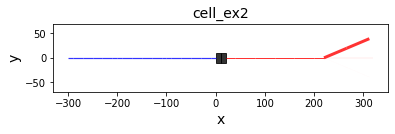

In [115]:
# Let's visualize what we've constructed!

import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

# In Noto
# save hoc object into ".swc" file
neuron2swc('cell_ex2.swc', swap_yz=False)
# Open the ".swc" and plot with NeuroM viewer
neuron1 = nm.load_neuron('cell_ex2.swc')
viewer.draw(neuron1)

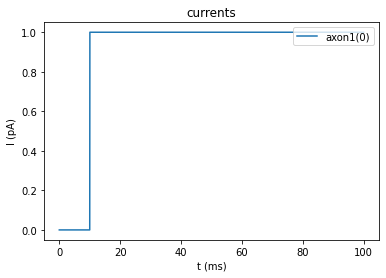

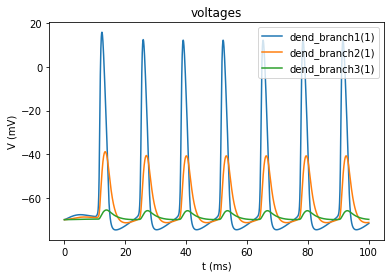

In [116]:
# Parameters testing:

time_delay = 10
amp = 1
dur = 500

##### Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma
### and the branches are recorded at the far end

reset()

## Setup stimulations and recordings

# Axon stimulated at the end closest to the soma (meaning the section closest to the soma, so axon 1 and at the end closest to the soma, so axon1(0))
iclamp(axon1(0), delay = time_delay, amplitude = amp, duration = dur)

# Record at the branches at the far end
vrecord(db1(1))
vrecord(db2(1))
vrecord(db3(1))

# Simulate and plot
v_init = -70
t_stop = 100

tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

#### - What are passive and active membrane properties?

The active membrane properties can be associated with the voltage-gated or ligand-gated ion channels.  These gated ion channels contribute to generating action potential and electrical signalling across neurons.  These active membrane properties sit on top of the passive properties linked to the cable properties of the membrane.  Indeed, the passive membrane properties don't have any gating system: the flow of ions depend mainly on the difference between intracellular and extracellular difference.  These leaky currents are also mediated by membrane protein, but they are not gated.

#### - What is going on with the signal propagation from the soma to the branches?

When the signal is emitted from the soma and propagates to the branches, the leaky properties of the membrane will induce a reduction of voltage.  Indeed, when looking at the cable equations that are used to model the membrane properties of neurons, a length constant is defined to characterize this voltage attenuation.  When the length constant is shorter, the signal is attenuated more strongly as it propagates and its amplitude is more and more reduced.  This length constant is defined as the square root of the ratio between the membrane resistance and the axial resistance.
$$ \lambda = \sqrt{\frac{r_{membrane}}{r_{axial}}} $$

Moreover, the smaller a surface is (ie the smaller the diameter is), the harder it is for ions to flow through and therefore the higher the axial resistance is.
For this reason, when decreasing the diameter of the branches, the axon resistance considerably increases and leads to a decrease of the length constant.  Therefore, the voltage amplitude is strongly attenuated in branches with smaller diameter, as observed in the plot above.

#### - What happen if the active properties of the dendrite are removed?

The same experiment is repeated, but the active properties of the dendrites are removed:

In [117]:
# Creating Neuron Sections
soma, dend, db1, db2, db3, axon1, axon2, axon3 = [h.Section(name=n) for n in ['soma', 'dend', 'dend_branch1', 'dend_branch2', 'dend_branch3', 'axon1', 'axon2', 'axon3']]

# SOMA SECTION
soma.L = 20       # length (µm)
soma.diam = 20    # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1       # capacitance (µF/cm^2) 

# AXON 1 SECTION
axon1.diam = 3
axon1.L = 100      # length (µm)
axon1.nseg = 5     # diameter (µm)
axon1.Ra = 123.0   # axial resistivity (Ω*cm)
axon1.cm = 1       # capacitance (µF/cm^2) 

# AXON 2 SECTION
axon2.diam = 3
axon2.L = 100      # length (µm)
axon2.nseg = 5     # diameter (µm)
axon2.Ra = 123.0   # axial resistivity (Ω*cm)
axon2.cm = 1       # capacitance (µF/cm^2) 

# AXON 3 SECTION
axon3.diam = 3
axon3.L = 100      # length (µm)
axon3.nseg = 5     # diameter (µm)
axon3.Ra = 123.0   # axial resistivity (Ω*cm)
axon3.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE SECTION
dend.L = 200       # length (µm)
dend.diam = 1     # diameter (µm)
dend.nseg = 5     # number of segments
dend.Ra = 123.0   # axial resistivity (Ω*cm)
dend.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE BRANCHES SECTIONS
# Long and thick
db1.L = 100
db1.diam = 3
db2.L = 100
db2.diam = 0.1
db3.L = 100
db3.diam = 0.01

# TOPOLOGY
axon1.connect(soma(0))
axon2.connect(axon1(1))
axon3.connect(axon2(1))
dend.connect(soma(1))
db1.connect(dend(1))
db2.connect(dend(1))
db3.connect(dend(1))

# INSERT PASSIVE PROPERTIES
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon1.insert('pas')
for seg in axon1:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon2.insert('pas')
for seg in axon2:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon3.insert('pas')
for seg in axon3:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

branchlst = [db1, db2, db3]

for branch in branchlst:
    branch.Ra = 130.0   # axial resistivity (Ω*cm)
    branch.cm = 1       # capacitance (µF/cm^2) 
    branch.insert('pas')
    for seg in branch:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
# INSERT ACTIVE PROPERTIES
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon1.insert('hh')
for seg in axon1:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon2.insert('hh')
for seg in axon2:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon3.insert('hh')
for seg in axon3:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

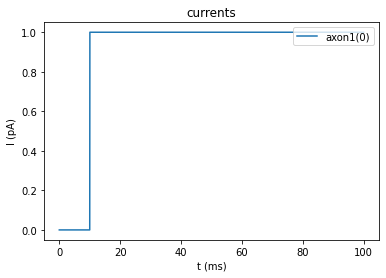

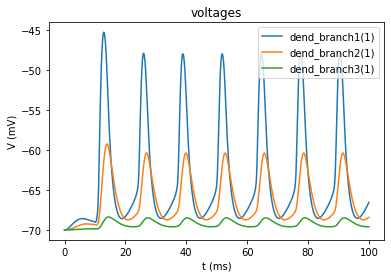

In [118]:
# Parameters testing:

time_delay = 10
amp = 1
dur = 500

##### Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma
### and the branches are recorded at the far end

reset()

## Setup stimulations and recordings

# Axon stimulated at the end closest to the soma
iclamp(axon1(0), delay = time_delay, amplitude = amp, duration = dur)

# Record at the branches at the far end
vrecord(db1(1))
vrecord(db2(1))
vrecord(db3(1))

# Simulate and plot
v_init = -70
t_stop = 100

tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

#### - What happen if the active properties of the dendrite are removed?

The same experience is realized and the active properties of the dendrites are removed. For the same exact conditions, we quickly realize that the voltage amplitude of the spikes is considerably reduced when the active properties of the dendrites are removed.
Indeed, the active properties of the dendrites allowed to activate the ion channels and help contribute to the propagation of the signal.  Whereas when they are turned off, the voltage is considerably reduced.  Moreover, one can note that the length constant reasoning in the previous section is (logically) conserved.  Indeed, the branch with the largest section and thus the lowest axial resisitivity has the biggest peak.

#### - Record the potential at the end of the axon. What happens if the active properties of the middle axonal section are removed? What could this represent biologically?

In [119]:
# Parameters testing:
time_delay = 10
amp = 1
dur = 500

In [120]:
# RECORDING POTENTIAL AT THE END OF AXON WHEN ALL SEGMENTS OF AXON HAVE ACTIVE PROPERTIES
# Creating Neuron Sections
soma, dend, db1, db2, db3, axon1, axon2, axon3 = [h.Section(name=n) for n in ['soma', 'dend', 'dend_branch1', 'dend_branch2', 'dend_branch3', 'axon1', 'axon2', 'axon3']]

# SOMA SECTION
soma.L = 20       # length (µm)
soma.diam = 20    # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1       # capacitance (µF/cm^2) 

# AXON 1 SECTION
axon1.diam = 3
axon1.L = 100      # length (µm)
axon1.nseg = 5     # diameter (µm)
axon1.Ra = 123.0   # axial resistivity (Ω*cm)
axon1.cm = 1       # capacitance (µF/cm^2) 

# AXON 2 SECTION
axon2.diam = 3
axon2.L = 100      # length (µm)
axon2.nseg = 5     # diameter (µm)
axon2.Ra = 123.0   # axial resistivity (Ω*cm)
axon2.cm = 1       # capacitance (µF/cm^2) 

# AXON 3 SECTION
axon3.diam = 30
axon3.L = 100      # length (µm)
axon3.nseg = 5     # diameter (µm)
axon3.Ra = 123.0   # axial resistivity (Ω*cm)
axon3.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE SECTION
dend.L = 200       # length (µm)
dend.diam = 1     # diameter (µm)
dend.nseg = 5     # number of segments
dend.Ra = 123.0   # axial resistivity (Ω*cm)
dend.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE BRANCHES SECTIONS
# Long and thick
db1.L = 100
db1.diam = 3
db2.L = 100
db2.diam = 0.1
db3.L = 100
db3.diam = 0.01

# TOPOLOGY
axon1.connect(soma(0))
axon2.connect(axon1(1))
axon3.connect(axon2(1))
dend.connect(soma(1))
db1.connect(dend(1))
db2.connect(dend(1))
db3.connect(dend(1))

# INSERT PASSIVE PROPERTIES
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon1.insert('pas')
for seg in axon1:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon2.insert('pas')
for seg in axon2:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon3.insert('pas')
for seg in axon3:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

branchlst = [db1, db2, db3]

for branch in branchlst:
    branch.Ra = 130.0   # axial resistivity (Ω*cm)
    branch.cm = 1       # capacitance (µF/cm^2) 
    branch.insert('pas')
    for seg in branch:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
# INSERT ACTIVE PROPERTIES
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon1.insert('hh')
for seg in axon1:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon2.insert('hh')
for seg in axon2:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon3.insert('hh')
for seg in axon3:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

dend.insert('hh')
for seg in dend:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

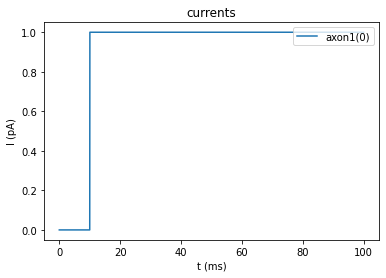

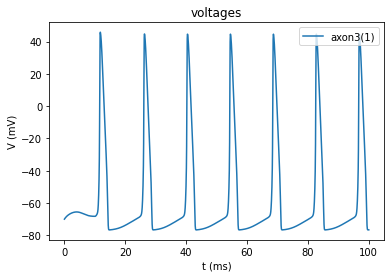

In [121]:
##### Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma
### and the branches are recorded at the far end

reset()

## Setup stimulations and recordings

# Axon stimulated at the end closest to the soma (meaning axon3 which is the section the furthest from the soma, and axon3(1) to that it is the end furtherst from the some)
iclamp(axon1(0), delay = time_delay, amplitude = amp, duration = dur)

# Record at the middle segment of the axon
vrecord(axon3(1))

# Simulate and plot
v_init = -70
t_stop = 100

tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

In [122]:
# RECORDING POTENTIAL AT THE END OF AXON WHEN MIDDLE SEGMENT OF AXON HAS NO ACTIVE PROPERTIES

# Creating Neuron Sections
soma, dend, db1, db2, db3, axon1, axon2, axon3 = [h.Section(name=n) for n in ['soma', 'dend', 'dend_branch1', 'dend_branch2', 'dend_branch3', 'axon1', 'axon2', 'axon3']]

# SOMA SECTION
soma.L = 20       # length (µm)
soma.diam = 20    # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1       # capacitance (µF/cm^2) 

# AXON 1 SECTION
axon1.diam = 3
axon1.L = 100      # length (µm)
axon1.nseg = 5     # diameter (µm)
axon1.Ra = 123.0   # axial resistivity (Ω*cm)
axon1.cm = 1       # capacitance (µF/cm^2) 

# AXON 2 SECTION
axon2.diam = 3
axon2.L = 100     # length (µm)
axon2.nseg = 5     # diameter (µm)
axon2.Ra = 123.0   # axial resistivity (Ω*cm)
axon2.cm = 1       # capacitance (µF/cm^2) 

# AXON 3 SECTION
axon3.diam = 3
axon3.L = 100      # length (µm)
axon3.nseg = 5     # diameter (µm)
axon3.Ra = 123.0   # axial resistivity (Ω*cm)
axon3.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE SECTION
dend.L = 200       # length (µm)
dend.diam = 1     # diameter (µm)
dend.nseg = 5     # number of segments
dend.Ra = 123.0   # axial resistivity (Ω*cm)
dend.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE BRANCHES SECTIONS
# Long and thick
db1.L = 100
db1.diam = 3
db2.L = 100
db2.diam = 0.1
db3.L = 100
db3.diam = 0.01

# TOPOLOGY
axon1.connect(soma(0))
axon2.connect(axon1(1))
axon3.connect(axon2(1))
dend.connect(soma(1))
db1.connect(dend(1))
db2.connect(dend(1))
db3.connect(dend(1))

# INSERT PASSIVE PROPERTIES
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon1.insert('pas')
for seg in axon1:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon2.insert('pas')
for seg in axon2:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon3.insert('pas')
for seg in axon3:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

branchlst = [db1, db2, db3]

for branch in branchlst:
    branch.Ra = 130.0   # axial resistivity (Ω*cm)
    branch.cm = 1       # capacitance (µF/cm^2) 
    branch.insert('pas')
    for seg in branch:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
# INSERT ACTIVE PROPERTIES
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon1.insert('hh')
for seg in axon1:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon3.insert('hh')
for seg in axon3:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

dend.insert('hh')
for seg in dend:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

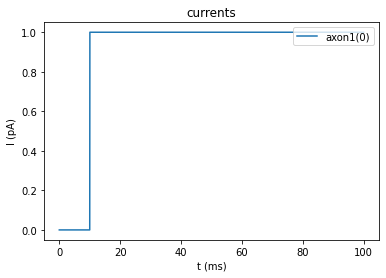

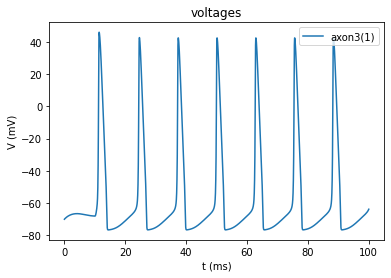

In [123]:
##### Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma
### and the branches are recorded at the far end

reset()

## Setup stimulations and recordings

# Axon stimulated at the end closest to the soma (meaning axon3 which is the section the furthest from the soma, and axon3(1) to that it is the end furtherst from the some)
iclamp(axon1(0), delay = time_delay, amplitude = amp, duration = dur)

# Record at the middle segment of the axon
vrecord(axon3(1))

# Simulate and plot
v_init = -70
t_stop = 100

tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

Given that no differences were noted between the two plots, we amplified the role of the axon 2 section by increasing its length.  Indeed, by increasing its length, the "passive gap" has a stronger and more notable effect (as seen below)

In [124]:
# RECORDING POTENTIAL AT THE END OF AXON WHEN ALL SEGMENTS OF AXON HAVE ACTIVE PROPERTIES
# Creating Neuron Sections
soma, dend, db1, db2, db3, axon1, axon2, axon3 = [h.Section(name=n) for n in ['soma', 'dend', 'dend_branch1', 'dend_branch2', 'dend_branch3', 'axon1', 'axon2', 'axon3']]

# SOMA SECTION
soma.L = 20       # length (µm)
soma.diam = 20    # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1       # capacitance (µF/cm^2) 

# AXON 1 SECTION
axon1.diam = 3
axon1.L = 100      # length (µm)
axon1.nseg = 5     # diameter (µm)
axon1.Ra = 123.0   # axial resistivity (Ω*cm)
axon1.cm = 1       # capacitance (µF/cm^2) 

# AXON 2 SECTION
axon2.diam = 3
axon2.L = 1000      # length (µm)
axon2.nseg = 5     # diameter (µm)
axon2.Ra = 123.0   # axial resistivity (Ω*cm)
axon2.cm = 1       # capacitance (µF/cm^2) 

# AXON 3 SECTION
axon3.diam = 30
axon3.L = 100      # length (µm)
axon3.nseg = 5     # diameter (µm)
axon3.Ra = 123.0   # axial resistivity (Ω*cm)
axon3.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE SECTION
dend.L = 200       # length (µm)
dend.diam = 1     # diameter (µm)
dend.nseg = 5     # number of segments
dend.Ra = 123.0   # axial resistivity (Ω*cm)
dend.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE BRANCHES SECTIONS
# Long and thick
db1.L = 100
db1.diam = 3
db2.L = 100
db2.diam = 0.1
db3.L = 100
db3.diam = 0.01

# TOPOLOGY
axon1.connect(soma(0))
axon2.connect(axon1(1))
axon3.connect(axon2(1))
dend.connect(soma(1))
db1.connect(dend(1))
db2.connect(dend(1))
db3.connect(dend(1))

# INSERT PASSIVE PROPERTIES
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon1.insert('pas')
for seg in axon1:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon2.insert('pas')
for seg in axon2:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon3.insert('pas')
for seg in axon3:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

branchlst = [db1, db2, db3]

for branch in branchlst:
    branch.Ra = 130.0   # axial resistivity (Ω*cm)
    branch.cm = 1       # capacitance (µF/cm^2) 
    branch.insert('pas')
    for seg in branch:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
# INSERT ACTIVE PROPERTIES
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon1.insert('hh')
for seg in axon1:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon2.insert('hh')
for seg in axon2:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon3.insert('hh')
for seg in axon3:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

dend.insert('hh')
for seg in dend:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

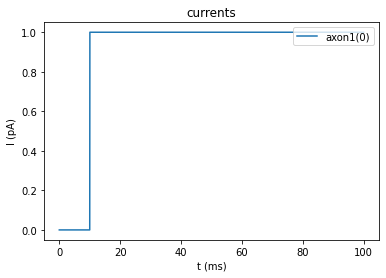

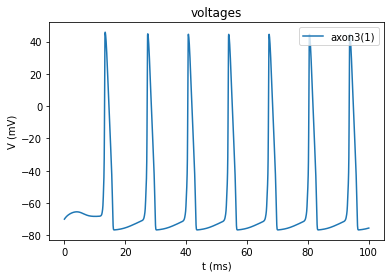

In [125]:
##### Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma
### and the branches are recorded at the far end

reset()

## Setup stimulations and recordings

# Axon stimulated at the end closest to the soma (meaning axon3 which is the section the furthest from the soma, and axon3(1) to that it is the end furtherst from the some)
iclamp(axon1(0), delay = time_delay, amplitude = amp, duration = dur)

# Record at the middle segment of the axon
vrecord(axon3(1))

# Simulate and plot
v_init = -70
t_stop = 100

tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

In [126]:
# RECORDING POTENTIAL AT THE END OF AXON WHEN MIDDLE SEGMENT OF AXON HAS NO ACTIVE PROPERTIES

# Creating Neuron Sections
soma, dend, db1, db2, db3, axon1, axon2, axon3 = [h.Section(name=n) for n in ['soma', 'dend', 'dend_branch1', 'dend_branch2', 'dend_branch3', 'axon1', 'axon2', 'axon3']]

# SOMA SECTION
soma.L = 20       # length (µm)
soma.diam = 20    # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1       # capacitance (µF/cm^2) 

# AXON 1 SECTION
axon1.diam = 3
axon1.L = 100      # length (µm)
axon1.nseg = 5     # diameter (µm)
axon1.Ra = 123.0   # axial resistivity (Ω*cm)
axon1.cm = 1       # capacitance (µF/cm^2) 

# AXON 2 SECTION
axon2.diam = 3
axon2.L = 1000     # length (µm)
axon2.nseg = 5     # diameter (µm)
axon2.Ra = 123.0   # axial resistivity (Ω*cm)
axon2.cm = 1       # capacitance (µF/cm^2) 

# AXON 3 SECTION
axon3.diam = 3
axon3.L = 100      # length (µm)
axon3.nseg = 5     # diameter (µm)
axon3.Ra = 123.0   # axial resistivity (Ω*cm)
axon3.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE SECTION
dend.L = 200       # length (µm)
dend.diam = 1     # diameter (µm)
dend.nseg = 5     # number of segments
dend.Ra = 123.0   # axial resistivity (Ω*cm)
dend.cm = 1       # capacitance (µF/cm^2) 

# DENDRITE BRANCHES SECTIONS
# Long and thick
db1.L = 100
db1.diam = 3
db2.L = 100
db2.diam = 0.1
db3.L = 100
db3.diam = 0.01

# TOPOLOGY
axon1.connect(soma(0))
axon2.connect(axon1(1))
axon3.connect(axon2(1))
dend.connect(soma(1))
db1.connect(dend(1))
db2.connect(dend(1))
db3.connect(dend(1))

# INSERT PASSIVE PROPERTIES
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon1.insert('pas')
for seg in axon1:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon2.insert('pas')
for seg in axon2:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

axon3.insert('pas')
for seg in axon3:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
dend.insert('pas')
for seg in dend:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential

branchlst = [db1, db2, db3]

for branch in branchlst:
    branch.Ra = 130.0   # axial resistivity (Ω*cm)
    branch.cm = 1       # capacitance (µF/cm^2) 
    branch.insert('pas')
    for seg in branch:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70    # Leak reversal potential, it influences the steady state membrane potential
    
# INSERT ACTIVE PROPERTIES
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon1.insert('hh')
for seg in axon1:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
    
axon3.insert('hh')
for seg in axon3:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

dend.insert('hh')
for seg in dend:
    seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

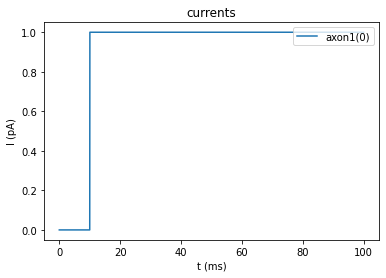

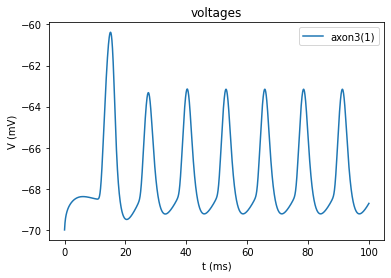

In [127]:
##### Perform a current clamp experiment in which the axon is stimulated at the end closest to the soma
### and the branches are recorded at the far end

reset()

## Setup stimulations and recordings

# Axon stimulated at the end closest to the soma (meaning axon3 which is the section the furthest from the soma, and axon3(1) to that it is the end furtherst from the some)
iclamp(axon1(0), delay = time_delay, amplitude = amp, duration = dur)

# Record at the middle segment of the axon
vrecord(axon3(1))

# Simulate and plot
v_init = -70
t_stop = 100

tvi_plots(initrun(v_init,t_stop),vdictlst,idictlst)

#### - What happens if the active properties of the middle axonal section are removed? What could this represent biologically?

When the active properties of the middle axonal section are removed, then the signal propagation is considerably reduced.  Indeed, the active mechanisms (sodium and potassium channels) help promote signal propagation.  When they are deactivated (no active properties introduced in axon2 section), signal propagation is much less efficient as the leaky currents contribute to reducing the voltage amplitude.

Moreover, despite the attenuation the signal undergoes when propagating through axon2 section, axon3's active properties manage to depolarize enough to continue with the signal propagation.  In the first case where the axon sections had the same length, the attenuation in axon2 did not lead to any obvious change.  However in the second case, when increasing the length of axon2, the signal's amplitude at the beginning of section axon3 was not sufficient enough to trigger action potential firing.  Therefore, what we measure in axon3 is the attenuated subthreshold signal.

Biologically speaking, the active properties can be resumed in the presence of the voltage-gated or ligand-gated ion channels, which depolarize and contribute to the propagation of signal.  Therefore, when deactive the active properties in axon2, that would correspond to pharmacologically blocking the properties of the ion channels on the specific axon2 section.

To takes things further, this phenomenon reminds us of the biological process of myelination and Nodes of Ranvier.  Indeed, the myelination (which could be modelled as an increase of membrane resistance (thus increase in length constant)) helps decrease the leaky properties (passive mechanisms) of the membrane.  Together, the myelination and Nodes of Ranvier (high density of ion channels, which can reflect the active properties of this exercise 2), help contribute to fast signal propagation. (saltatory conduction)

# Ex 3. Dendritic input signal sumation in the soma

<font size="3">Load the morphology file for your group, and instanciate it as it is done on tutorial 03. Perform a current clamp experiment that stimulates all the dendrites (basal and apical) in the middle. Play arround with the different stimulation parameters: delay, amplitude and duration.

<font size="3">Plot some results that would help you to explain: what is dendritic signal integration? and in your opinion, what is the importance of this in biology?
    
<font size="3">What happens when you stimulate only the basal or only the apical dendrites? Why is this?
    
[3 points]

In [128]:
# Loading file from our Group 1:
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

In [129]:
class NEURON:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()
        
    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # If we have a .swc morphology file
        cell = h.Import3d_Neurolucida3() # If we have an .asc morphology file

        # Read the file and creates automatically section.connect(parent) statements
        cell.input('Group1_morphology.asc')

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.dendritic = []
        self.apical = []
        self.axonal = []
        self.all = []
        for sec in h.allsec():
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.dendritic.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            if 'axon' in sec.name():
                self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and hh active prop on the soma and dendrites
        """   
        # Define passive properties for all sections
        for sec in h.allsec():
            sec.insert('pas')
            sec.nseg = 1
            for seg in sec:
                seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
                seg.pas.e = -70
        
        # Define active properties for soma, dendrite, apical dendrite and axon
        for sec in self.somatic:
            # insert hh
            sec.insert('hh')
            sec.Ra = 1
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.dendritic:
            # insert hh
            sec.insert('hh')
            sec.Ra = 300
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.apical:
            # insert hh
            sec.insert('hh')
            sec.Ra = 400
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.axonal:
            # insert hh
            sec.insert('hh')
            sec.Ra = 100
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

In [130]:
Cell = NEURON()


19847 lines read


In [131]:
# Plot current and voltage for all stims and recordings
# Redefining function in order to remove the legend
def tvi_plots_no_legend(t, vdictlst = [], idictlst = [], vmax = 40, imax = 0.5):
    plt.figure()
    plt.title('currents')
    plt.xlabel('t (ms)')
    plt.ylabel('I (pA)')
    for idict in idictlst:
        plt.plot(t,idict['vec'],label=idict['loc'])
    
    plt.figure()
    plt.title('voltages')
    #plt.ylim((-71,vmax))
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    for vdict in vdictlst:
        plt.plot(t,vdict['vec'],label=vdict['loc'])


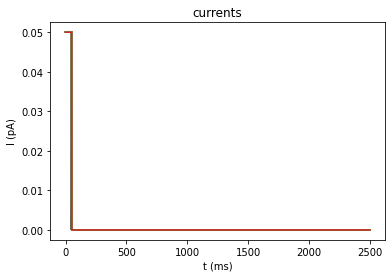

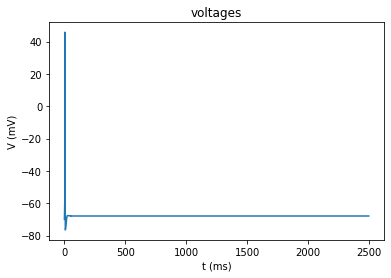

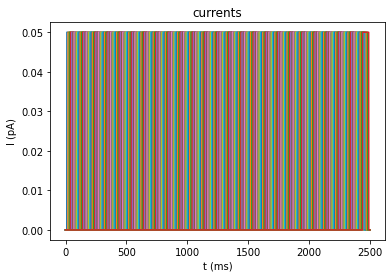

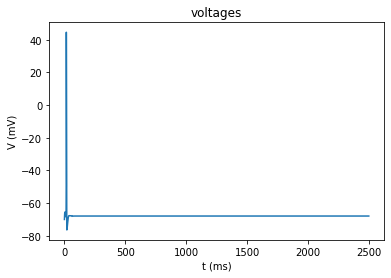

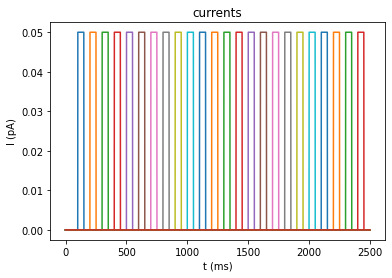

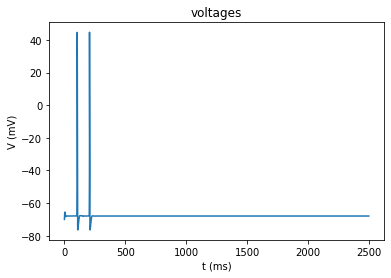

In [132]:
# Perform a current clamp that stimulates all the dendrites (basal and apical) in the middle
# Play around with different parameters: delay, amplitude and duration
delay_time_values = [0, 10, 100]
amp = 0.05
dur = 50
v_init = -70
t_stop = 2500

for delay_time in delay_time_values:
    reset()
    dendrite_list = Cell.dendritic + Cell.apical

    # Setup stimulations and recordings
    for idx,dendrites in enumerate(dendrite_list):
        iclamp(dendrites(0.5), amplitude = amp, delay = delay_time +idx*delay_time , duration = dur)
    vrecord(Cell.somatic[0](0.5))

    # Simulate and plot
    tvi_plots_no_legend(initrun(v_init,t_stop),vdictlst,idictlst,vmax = -65)

#### Plot some results that would help to explain: What is dendritic signal integration? And what is the importance of this in biology?

Dendritic singal integration can be defined as the integration and computation of the numerous incoming dendritic inputs at the level of the soma.  Indeed, dendrites can be considered as the receiving element of neurons, picking up signals from presynaptic inputs.  The dendrites' geometric diversity as well as their passive and active properties, enable the neurons to perform complex computation.  Indeed, when playing with the properties of dendrites, as well as the time difference of incoming dendritic input, this gives the neuron the possibility to perform a wide range of nonlinear operations (such as AND, OR, XOR).  For instance, AND opperations can occur when the dendritic input is sufficiently synchronized. [interesting article about dendritic signal integration](https://www.nature.com/articles/nn.4157)

In the plots above, we highlighted this AND operation phenomenon.  We progressively increased the delay times (0, 10 and 100 ms), of the incoming dendritic signals.  We noted that if the delay time is short, the recording at the soma reveals action potentials.  However, when increasing the delay time, the number of action potential considerably reduces.  Indeed, an action potential is triggered when enough incoming dendritic signal is present and thus accumulates to cross a threshold.

When the delay was 0 ms, the probability of having an action potential at the level of the soma was high enough to cause an action potential immediately.  When we increased the delay (to 10 ms), the dendritic signals are slightly delayed and decrease the probability of firing.  However, these incoming dendritic signals span over a period of time long enough and are synchronized enough, to trigger action potentials.  In the last scenario, when the delay was 100ms, the dendritic input was not synchronized enough to reliably cause firing.

Biologically speaking, the complexity of dendritic signal integration allows the neuron to perform higher complex operation.  Therefore, it does not act as a single cable propagating information, but can code for more diversified logical operations. (analogy with computer logical gates)

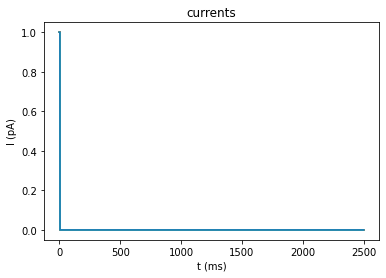

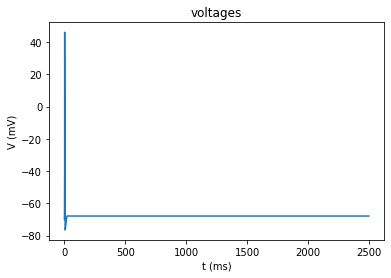

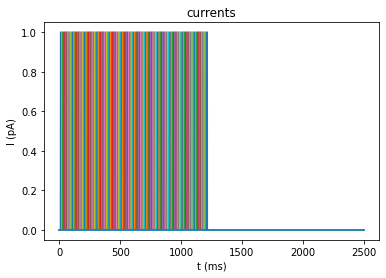

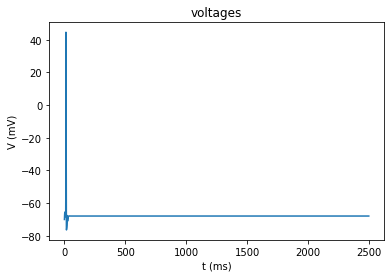

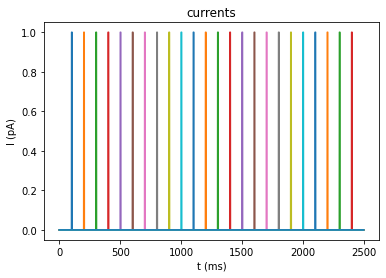

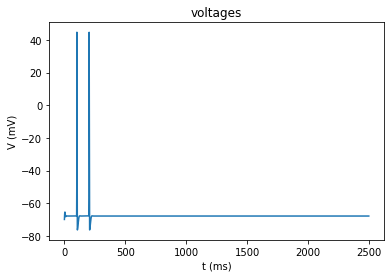

In [133]:
# Stimulating only the basal dendrites
delay_time_values = [0, 10, 100]
amp = 1
dur = 5
v_init = -70
t_stop = 2500

for delay_time in delay_time_values:
    reset()
    dendrite_list = Cell.dendritic

    # Setup stimulations and recordings
    for idx,dendrites in enumerate(dendrite_list):
        iclamp(dendrites(0.5), amplitude = amp, delay = delay_time +idx*delay_time , duration = dur)
    vrecord(Cell.somatic[0](0.5))

    # Simulate and plot
    tvi_plots_no_legend(initrun(v_init,t_stop),vdictlst,idictlst,vmax = -65)

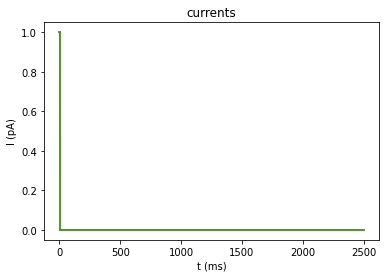

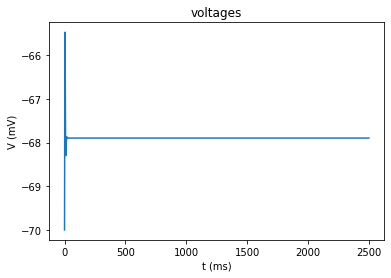

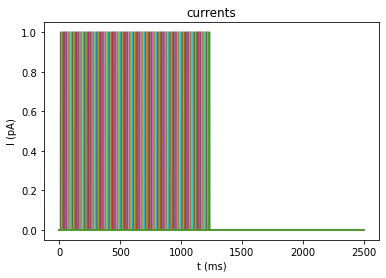

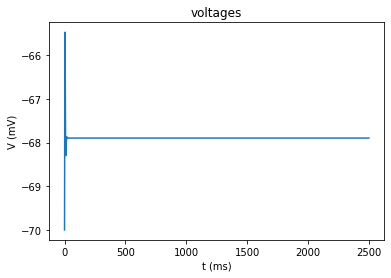

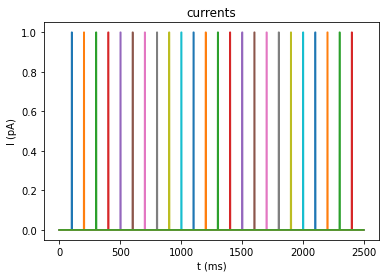

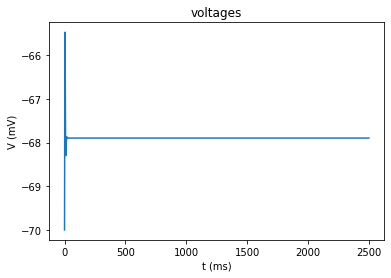

In [134]:
# Stimulating only the apical dendrits
delay_time_values = [0, 10, 100]
amp = 1
dur = 5
v_init = -70
t_stop = 2500

for delay_time in delay_time_values:
    reset()
    dendrite_list = Cell.apical

    # Setup stimulations and recordings
    for idx,dendrites in enumerate(dendrite_list):
        iclamp(dendrites(0.5), amplitude = amp, delay = delay_time +idx*delay_time , duration = dur)
    vrecord(Cell.somatic[0](0.5))

    # Simulate and plot
    tvi_plots_no_legend(initrun(v_init,t_stop),vdictlst,idictlst,vmax = -65)

#### What happens when you stimulate only the basal or only the apical dendrites? Why is this?

The distinct morphologies of basal and apical dendrites suggest that inputs to these domains might be
integrated differently.

Morphologically speaking, the apical dendrites are of longer length than the basal dendrites.  This difference in morphology can potentially lead in different types of somatic integration.  Indeed, injecting current for smaller durations manages to highlight a difference in firing between basal and apical dendrites.  For basal dendrites, given they are of shorter distance, the current injection of small duration manages to be picked up and lead to firing in the soma.  On the other hand, current injections with the same small duration in apical dendrites leads to no action potential firing in the soma.

# Ex 4. Signal attenuation: dendrites vs axon

<font size="3">Load the morphology file for your group, and instanciate it as it is done on tutorial 03. Perform a current clamp experiment in which the soma is stimulated in the middle (find the stimulation parameters that support your explanation better). Record the back propagating signals of the dendrites and the forward signal in the axon.

<font size="3">What would you expect in terms of attenuation? Would you expect the signal to be more attenuated in the axon or in the dendrites? Why? Change the properties of some of the sections, such that you get a different result. Explain why this works.
    
[1.75 points]

### Let's take a look at the morphology of the neuron we are working with:

Visualizing our neuron using NeuroMorphoVis: 



<img src="cell.png">

In [24]:
# We then tried to look at the connectivity to see which axons were most likely the furthest out

h.load_file('stdlib.hoc')
h.load_file("import3d.hoc")
#cell = h.Import3d_SWC_read() # If we have a .swc morphology file
ccell = h.Import3d_Neurolucida3() # If we have an .asc morphology file

# Read the file and creates automatically section.connect(parent) statements
ccell.input('Group1_morphology.asc')
ccell = h.Import3d_GUI(ccell,0)
ccell.instantiate(None) 

h.topology()


19847 lines read

|-|       soma[0](0-1)
  `|       axon[0](0-1)
    `|       axon[1](0-1)
      `|       axon[2](0-1)
        `|       axon[3](0-1)
          `|       axon[4](0-1)
          `|       axon[5](0-1)
            `|       axon[6](0-1)
              `|       axon[7](0-1)
              `|       axon[8](0-1)
                `|       axon[9](0-1)
                `|       axon[10](0-1)
            `|       axon[11](0-1)
              `|       axon[12](0-1)
                `|       axon[13](0-1)
                  `|       axon[14](0-1)
                    `|       axon[15](0-1)
                      `|       axon[16](0-1)
                      `|       axon[17](0-1)
                        `|       axon[18](0-1)
                        `|       axon[19](0-1)
                    `|       axon[20](0-1)
                  `|       axon[21](0-1)
                `|       axon[22](0-1)
              `|       axon[23](0-1)
        `|       axon[24](0-1)
          `|       axon[25](0-1)


1.0

In [25]:
neuron_ = nm.load_neuron('Group1_morphology.asc')

radii = nm.get('segment_radii',neuron_,neurite_type=nm.NeuriteType.apical_dendrite)
print(np.mean(radii))

radii = nm.get('segment_radii',neuron_,neurite_type=nm.NeuriteType.basal_dendrite)
print(np.mean(radii))

radii = nm.get('segment_radii',neuron_,neurite_type=nm.NeuriteType.axon)
print(np.mean(radii))

0.44022644927536225
0.4086920017675652
0.22076413452032226


When comparing the average radii of the apical, basal and axon, one notices that the radius of the axon is considerably smaller than those of the dendrites.

In [32]:
# Plot current and voltage for all stims and recordings
def tvi_plots_changed_legend_ex4(t, vdictlst = [], idictlst = [], vmax = 40, imax = 0.5):
    plt.figure()
    plt.title('currents')
    plt.xlabel('t (ms)')
    plt.ylabel('I (pA)')
    for idict in idictlst:
        plt.plot(t,idict['vec'],label=idict['loc'])
    plt.legend(loc=1)
    
    plt.figure()
    plt.title('voltages')
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    for i,vdict in enumerate(vdictlst):
        plt.plot(t,vdict['vec'],label=vdict['loc'])
    plt.legend(loc=1)

#### What would you expect in terms of attenuation? Would you expect the signal to be more attenuated in the axon or in the dendrites? Why? Change the properties of some of the sections, such that you get a different result. Explain why this works

In terms of attenuation, we expect that the signal is more strongly attenuated in the dendrites than in the axon.  Indeed, we expect that the attenuation in the axon to be smaller, given that the "purpose" of the axon is to propagate action potentials to the synaptic bouton and transmit information (in other words we expect [passive itegration](https://www.nature.com/articles/nn.4157).

However, when injecting current in the soma and recording in both the axon and neurites (where both axon and dendrites have active properties), we suprisingly observe that the propagation is considerably more efficient in the dendrites.



In [33]:
# Loading file from our Group 1:
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

class NEURON_EX4:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()
        
    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # If we have a .swc morphology file
        cell = h.Import3d_Neurolucida3() # If we have an .asc morphology file

        # Read the file and creates automatically section.connect(parent) statements
        cell.input('Group1_morphology.asc')

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.dendritic = []
        self.apical = []
        self.axonal = []
        self.all = []
        for sec in h.allsec():
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.dendritic.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            if 'axon' in sec.name():
                self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and hh active prop on the soma and dendrites
        """   
        # Define passive properties for all sections
        for sec in h.allsec():
            sec.insert('pas')
            sec.nseg = 1
            for seg in sec:
                seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
                seg.pas.e = -70
        
        # Define active properties for soma, dendrite, apical dendrite and axon
        for sec in self.somatic:
            # insert hh
            sec.insert('hh')
            sec.Ra = 1
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.dendritic:
#             # insert hh
            sec.insert('hh')
            sec.Ra = 300
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.apical:
            # insert hh
            sec.insert('hh')
            sec.Ra = 400
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.axonal:
            # insert hh
            sec.insert('hh')
            sec.Ra = 100
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4 # Maximal conductance of the sodium channels

In [34]:
# Global containers for objects
stimdictlst_ex4 = [] # stimulations
vdictlst_ex4 = []    # voltage recordings
idictlst_ex4 = []    # current recordings

def reset_ex4():
    del stimdictlst_ex4[:]
    del vdictlst_ex4[:]
    del idictlst_ex4[:]

# Inject a current step with parameters at location
def iclamp_ex4(location, delay, amplitude, duration):
    stim = h.IClamp(location) # Place a stimulation electrode at location
    stim.delay = delay   # stim delay (ms)
    stim.amp = amplitude # stim amplitude (pA)
    stim.dur = duration  # stim duration (ms)
    stimdictlst_ex4.append({ 'stim': stim, 'loc': str(location) })
    return stim

# Setup recording of voltage at location
def vrecord_ex4(location):
    vec = h.Vector()
    vec.record(location._ref_v) # record voltage at location
    vdictlst_ex4.append({ 'vec': vec, 'loc': str(location) })
    return vec

# Setup recording of stimulation current
def irecord_ex4(stimdict):
    vec = h.Vector()
    vec.record(stimdict['stim']._ref_i) # record stimulation current
    idictlst_ex4.append({ 'vec': vec, 'loc': stimdict['loc'] })
    return vec

# Initialize and run a simulation
def initrun_ex4(v_i,t_stop):
    # Record time
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record current for all stimuli
    for stimdict in stimdictlst_ex4:
        irecord_ex4(stimdict)
    # Setup simulation and run
    h.load_file('stdrun.hoc')
    h.finitialize(v_i) # initial voltage
    h.continuerun(t_stop) # final time
    return rec_t

In [35]:
# Load morphology file for Group 1:

# Note: the Neuron class was imported in the previous exercise, if the kernel was restarted then just that cell needs to be re-ran
Cell_Ex4 = NEURON_EX4()


19847 lines read


In [36]:
# Parameters to play with:
delay_time = 100
amp = 5
dur = 50

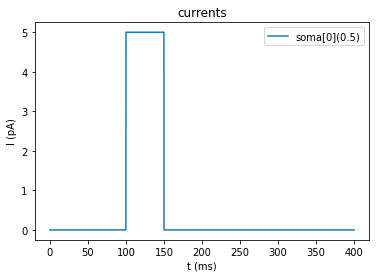

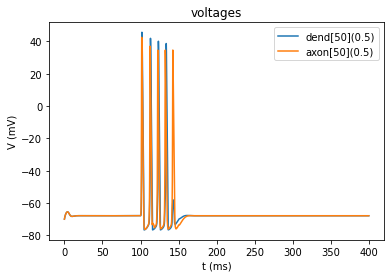

In [37]:
# Perform a current clamp experiment in which the soma is stimulated in the middle
# (find the stimulation parameters that support your explanation better)

reset_ex4()

# Place a stimulation electrode in the middle of the soma
iclamp_ex4(Cell_Ex4.somatic[0](0.5), amplitude = amp, delay = delay_time, duration = dur)

# Recording backpropagation signals of the dendrites
dendrites = Cell_Ex4.apical

#for idx,dendrites in enumerate(dendrite_list[10:31]):
#    vrecord(dendrites(0.5))
vrecord_ex4(Cell_Ex4.dendritic[50](0.5))
vrecord_ex4(Cell_Ex4.axonal[50](0.5))

# Simulate and plot
v_init = -70
t_stop = 400
tvi_plots_changed_legend_ex4(initrun_ex4(v_init,t_stop),vdictlst_ex4,idictlst_ex4,vmax = -65)

#### Modifying section properties to have stronger attenuation in dendrites than in soma

In order to obtain more efficient propagation down the axon compared to the dendrites, we deactivated the active properties in the dendrites and not in the axon.  In this particular case, when turning off the properties we are noting that the signal propagates down the axon but not in the dendrites (thus confirming what we were expecting initially).

In [38]:
# Loading file from our Group 1:
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

class NEURON_EX4_NO_DENDRITE_PROP:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()
        
    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # If we have a .swc morphology file
        cell = h.Import3d_Neurolucida3() # If we have an .asc morphology file

        # Read the file and creates automatically section.connect(parent) statements
        cell.input('Group1_morphology.asc')

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.dendritic = []
        self.apical = []
        self.axonal = []
        self.all = []
        for sec in h.allsec():
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.dendritic.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            if 'axon' in sec.name():
                self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and hh active prop on the soma and dendrites
        """   
        # Define passive properties for all sections
        for sec in h.allsec():
            sec.insert('pas')
            sec.nseg = 1
            for seg in sec:
                seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
                seg.pas.e = -70
        
        # Define active properties for soma, dendrite, apical dendrite and axon
        for sec in self.somatic:
            # insert hh
            sec.insert('hh')
            sec.Ra = 1
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels
        
        for sec in self.axonal:
            # insert hh
            sec.insert('hh')
            sec.Ra = 100
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1   # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4 # Maximal conductance of the sodium channels

In [39]:
# Load morphology file for Group 1:

# Note: the Neuron class was imported in the previous exercise, if the kernel was restarted then just that cell needs to be re-ran
Cell_Ex4 = NEURON_EX4_NO_DENDRITE_PROP()


19847 lines read


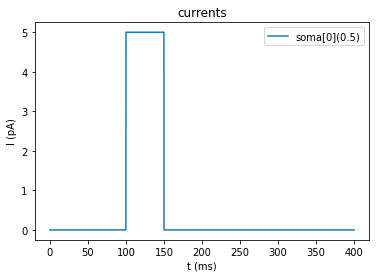

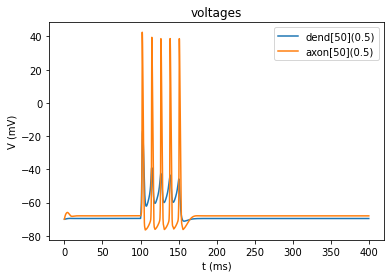

In [40]:
# In Case of No Active Properties in any section

reset_ex4()

# Place a stimulation electrode in the middle of the soma
iclamp_ex4(Cell_Ex4.somatic[0](0.5), amplitude = amp, delay = delay_time, duration = dur)

# Recording backpropagation signals of the dendrites
dendrites = Cell_Ex4.apical

#for idx,dendrites in enumerate(dendrite_list[10:31]):
#    vrecord(dendrites(0.5))
vrecord_ex4(Cell_Ex4.dendritic[50](0.5))
vrecord_ex4(Cell_Ex4.axonal[50](0.5))

# Simulate and plot
v_init = -70
t_stop = 400
tvi_plots_changed_legend_ex4(initrun_ex4(v_init,t_stop),vdictlst_ex4,idictlst_ex4,vmax = -65)

#### Deactivating all active properties to take a closer look at morphology:

In the last case, we deactivated the active properties in both the axon and the dendrites, in order to observe the propagation efficacy that only depended on the morphology of the neuron.  This deactivation could simulate a subthreshold behavior.  In this case, we notice that the propagation is still considerably more efficient in the dendrites then in the axon.  This makes sense when looking at the average radii of the sections obtained above, which is twice the size in dendrites (~0.4 compared to ~0.2) than in axons.  Indeed, having a larger diameter corresponds to having a smaller axial resistance and as a result, longer propagation length constant.  This would explain the difference in attenuation that we are observing.

In [44]:
# Loading file from our Group 1:
%matplotlib inline
from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import viewer
from hoc2swc import neuron2swc

class NEURON_EX4_NO_ACTIVE:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()
        
    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file('stdlib.hoc')
        h.load_file("import3d.hoc")
        #cell = h.Import3d_SWC_read() # If we have a .swc morphology file
        cell = h.Import3d_Neurolucida3() # If we have an .asc morphology file

        # Read the file and creates automatically section.connect(parent) statements
        cell.input('Group1_morphology.asc')

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell,0)
        self.importedcell.instantiate(None) 

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.dendritic = []
        self.apical = []
        self.axonal = []
        self.all = []
        for sec in h.allsec():
            if 'soma' in sec.name():
                self.somatic.append(sec)
            if 'dend' in sec.name():
                self.dendritic.append(sec)
            if 'apic' in sec.name():
                self.apical.append(sec)
            if 'axon' in sec.name():
                self.axonal.append(sec)
    
    def define_biophysics(self):
        """
        Distributes passive mechanisms and hh active prop on the soma and dendrites
        """   
        # Define passive properties for all sections
        for sec in h.allsec():
            sec.insert('pas')
            sec.nseg = 1
            for seg in sec:
                seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
                seg.pas.e = -70

In [45]:
# Load morphology file for Group 1:

# Note: the Neuron class was imported in the previous exercise, if the kernel was restarted then just that cell needs to be re-ran
Cell_Ex4 = NEURON_EX4_NO_ACTIVE()


19847 lines read


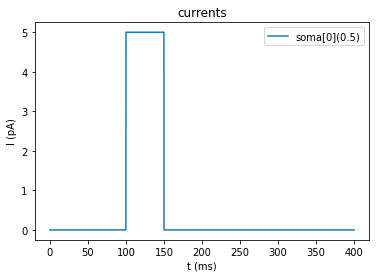

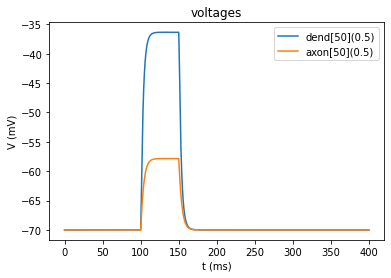

In [46]:
# In Case of No Active Properties in Dendritic section

reset_ex4()

# Place a stimulation electrode in the middle of the soma
iclamp_ex4(Cell_Ex4.somatic[0](0.5), amplitude = amp, delay = delay_time, duration = dur)

# Recording backpropagation signals of the dendrites
dendrites = Cell_Ex4.apical

#for idx,dendrites in enumerate(dendrite_list[10:31]):
#    vrecord(dendrites(0.5))
vrecord_ex4(Cell_Ex4.dendritic[50](0.5))
vrecord_ex4(Cell_Ex4.axonal[50](0.5))

# Simulate and plot
v_init = -70
t_stop = 400
tvi_plots_changed_legend_ex4(initrun_ex4(v_init,t_stop),vdictlst_ex4,idictlst_ex4,vmax = -65)


#### Lastly, some thoughts

Lastly, according to [figure 1.A-1.C in this article](https://www.nature.com/articles/nn.4157), for some neurons the APs propagate down the axon and into the dendritic tree to interact with the synaptic input.  As a result, we are considering this neuron to fall in that particular category (backpropagation).